In [1]:
import sys
print(sys.version)
print(*sys.path, sep='\n')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/lukec/venv/lib/python3.6/site-packages
/home/lukec/Downloads/jax/build
/home/lukec/.local/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/home/lukec/venv/lib/python3.6/site-packages/IPython/extensions
/home/lukec/.ipython


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [4]:
# parameters for trained CNN
ROOT = os.path.join('.', 'dataset_root')
MODEL_PATH = 'mnist_autoencoder.pt'

BATCH_SIZE = 64

MOMENTUM=0.9
LEARNING_RATE = 1e-2  # this is for training the parameters in fully connected layers
STEP_SIZE=6
GAMMA=0.1

EPOCHS = 40

In [5]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [6]:
# prepare data
# foolbox model expects raw numpy array as image
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
])
train_dataset = tv.datasets.MNIST(
    ROOT,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    ROOT,
    train=False, 
    download=True,
    transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, batch_size=BATCH_SIZE):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 2),
            nn.ReLU(),
            nn.Upsample((26, 26), mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(32, 1, 3, 1),
            nn.Tanh())
                
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() == (self.batch_size, 1, 28, 28)
        return self.encoder(x)
    
    def decode(self, x):
        assert isinstance(x, torch.Tensor) \
            and x.size() in ((self.batch_size, 128, 1, 1), (self.batch_size, 128))
        
        if x.size() == (self.batch_size, 128):
            x = x.view(self.batch_size, 128, 1, 1)
        
        return self.decoder(x)

In [8]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(MODEL_PATH))
autoencoder.eval()
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Upsample(size=(26, 26), mode=bilinear)
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
    (8): Tanh()
  )
)

In [9]:
# extract encoder
for name, module in autoencoder.named_children():
    if name == 'encoder':
        encoder = module

# freeze the encoder. Set gradients to readonly
for p in encoder.parameters():
    p.requires_grad = False

In [10]:
# the neural network without softmax layer
cnn = nn.Sequential(
    encoder,
    nn.Flatten(1),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10))

# the complete neural network for classification
model = nn.Sequential(
    cnn,
    nn.LogSoftmax(dim=1))
model.to(device)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    )
    (1): Flatten()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (1): LogSoftmax()
)

In [11]:
# sanity check
images = next(iter(train_loader))[0]
images = images.to(device)
output = model(images)
print(output.size())

torch.Size([64, 10])


In [12]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
        
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        output = model(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()

        # for display
        total_loss += loss.item() * batch_size
        preds = output.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [13]:
def validate(model, loader):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            loss = F.nll_loss(output, y)
            total_loss += loss.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [14]:
class EarlyStopping:
    def __init__(
            self, 
            patience=5, 
            delta=0, 
            path='checkpoint.pt'):
        self.patience = patience
        self.countdown = patience
        self.lowest_loss = 1e10
        self.early_stop = False
        self.delta = delta
        self.path = path
    
    def __call__(self, loss, model):
        if loss > self.lowest_loss * (1-self.delta):
            self.countdown -= 1
            print(f'Early stopping countdown: [{self.countdown}]')
            if self.countdown <= 0:
                self.early_stop = True
        else:
            self.countdown = self.patience
            self.lowest_loss = loss
            self.save_checkpoint_(model)
        
        return self.early_stop
    
    def save_checkpoint_(self, model):
        torch.save(model.state_dict(), self.path)
        
    def load_checkpoint(self):
        return torch.load(self.path)

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=STEP_SIZE, 
    gamma=GAMMA)

In [16]:
tr_losses = []
va_losses = []
early_stop = EarlyStopping()

since = time.time()
for epoch in range(EPOCHS):
    start = time.time()
    tr_loss, tr_acc = train(model, train_loader, optimizer)
    va_loss, va_acc = validate(model, test_loader)
    
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            tr_loss, tr_acc*100.,
            va_loss, va_acc*100.))
        
    tr_losses.append(tr_loss)
    va_losses.append(va_loss)
    
    # early stopping
    if early_stop(va_loss, model):
        checkpoint = early_stop.load_checkpoint()
        model.load_state_dict(checkpoint)
        break
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[ 1] 0m 2.1s Train Loss: 0.2662 Accuracy: 92.5167%, Test Loss: 0.1193 Accuracy: 96.2900%
[ 2] 0m 2.0s Train Loss: 0.1097 Accuracy: 96.7800%, Test Loss: 0.0897 Accuracy: 97.4300%
[ 3] 0m 1.9s Train Loss: 0.0863 Accuracy: 97.3083%, Test Loss: 0.0747 Accuracy: 97.7300%
[ 4] 0m 2.2s Train Loss: 0.0723 Accuracy: 97.7483%, Test Loss: 0.0679 Accuracy: 97.9100%
[ 5] 0m 2.0s Train Loss: 0.0625 Accuracy: 98.0417%, Test Loss: 0.0607 Accuracy: 98.2300%
[ 6] 0m 2.0s Train Loss: 0.0555 Accuracy: 98.2867%, Test Loss: 0.0588 Accuracy: 98.1300%
[ 7] 0m 2.1s Train Loss: 0.0497 Accuracy: 98.4617%, Test Loss: 0.0518 Accuracy: 98.4200%
[ 8] 0m 2.0s Train Loss: 0.0447 Accuracy: 98.6067%, Test Loss: 0.0528 Accuracy: 98.3000%
EarlyStopping countdown: [4]
[ 9] 0m 2.0s Train Loss: 0.0406 Accuracy: 98.7350%, Test Loss: 0.0517 Accuracy: 98.3200%
[10] 0m 2.1s Train Loss: 0.0373 Accuracy: 98.8533%, Test Loss: 0.0469 Accuracy: 98.4600%
[11] 0m 2.0s Train Loss: 0.0338 Accuracy: 98.9717%, Test Loss: 0.0466 Accuracy: 9

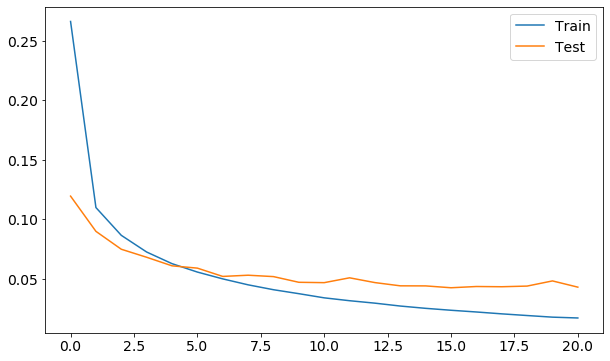

In [24]:
plt.figure(figsize=[10, 6])
plt.rcParams['font.size'] = 14
plt.plot(tr_losses, label='Train')
plt.plot(va_losses, label='Test')
plt.legend()
plt.show()

In [25]:
PATH = 'mnist_autoencoder_cnn.pt'
torch.save(model.state_dict(), PATH)